# Installing and using pysmurf on your own machine

pysmurf is a public github repo and can be downloaded here - <a href="https://github.com/eyyoung24/pysmurf">https://github.com/eyyoung24/pysmurf</a>.  Fair warning - we're likely to move the repo soon.

pysmurf requires python3 and the pyepics package.  Installing python3 in Linux is straightforward (if it's not on your machine already).  I'm writing this on a Windows laptop where I have python3 installed via anaconda3 - I have the Python3.6 version installed from here - <a href="https://www.anaconda.com/distribution/#download-section">https://www.anaconda.com/distribution/#download-section</a>. We will be requiring Python 3.7 soon. 

You should be able to install pyepics using pip - find instructions on that here - <a href="http://cars9.uchicago.edu/software/python/pyepics3/installation.html">http://cars9.uchicago.edu/software/python/pyepics3/installation.html</a>.  The terminal command is;

If you're running anaconda on Windows you can just run that command on an anaconda prompt (type "anaconda prompt" in the search bar) to install pyepics.

Last, pysmurf doesn't yet have an installer, so you'll have to either add the directory its in to your PYTHONPATH, or add it in your python session.  Here's an example for how to add it to the path of a running python session (this is horrible, but I have to do it because I don't have admin privileges on my SLAC laptop):

In [5]:
import sys
# pysmurf on my machine is in C:\Users\shawn\Documents\GitHub\
sys.path.append('C:\\Users\\shawn\\Documents\\GitHub\\')
import pysmurf
print(pysmurf)

<module 'pysmurf' from 'C:\\Users\\shawn\\Documents\\GitHub\\pysmurf\\__init__.py'>


If you're not on a SMuRF server, you'll need to instatiate pysmurf with a flag telling it not to try and talk to the EPICs server (and other things).  You'll also need to tell it where the cfg file the data was taken with is (as of right now - we need a better strategy for this).  Here's stupid way to find the path to your pysmurf's config file directory:

In [6]:
import os
pysmurf_cfg_file_dir=os.path.join(os.path.dirname(pysmurf.__file__),'cfg_files')
pysmurf_cfg_file_path=os.path.join(pysmurf_cfg_file_dir,'experiment_fp28_smurfsrv04.cfg')

print('pysmurf_cfg_file_dir=%s'%pysmurf_cfg_file_dir)
print('pysmurf_cfg_file_path=%s'%pysmurf_cfg_file_path)
os.path.exists(pysmurf_cfg_file_path)

pysmurf_cfg_file_dir=C:\Users\shawn\Documents\GitHub\pysmurf\cfg_files
pysmurf_cfg_file_path=C:\Users\shawn\Documents\GitHub\pysmurf\cfg_files\experiment_fp28_smurfsrv04.cfg


True

After running the above, you can instantiate an offline pysmurf instance using that cfg file via

In [7]:
S=pysmurf.SmurfControl(offline=True, no_dir=True, epics_root='test_epics', \
                      cfg_file=pysmurf_cfg_file_path)

[ 2019-03-07 21:17:13 ]  Offline mode
Warning! Not making output directories!This will break may things!


# SMuRF example data in this tutorial

This tutorial has some SMuRF data in it for you to try loading on your own machine offline.  That data is in the smurf_tutorials/example_data directory (not in git).

In [8]:
!dir example_data

 Volume in drive C has no label.
 Volume Serial Number is 7A0F-018B

 Directory of C:\Users\shawn\Documents\GitHub\smurf_tutorials\example_data

03/07/2019  09:15 PM    <DIR>          .
03/07/2019  09:15 PM    <DIR>          ..
02/04/2019  12:12 AM    <DIR>          1548916176
02/04/2019  12:12 AM    <DIR>          1549243856
03/07/2019  09:15 PM    <DIR>          tune
               0 File(s)              0 bytes
               5 Dir(s)  424,844,259,328 bytes free


Shawn is hosting the example data here for now - http://tinyurl.com/y4m3xclj.

# SMuRF data

This tutorial shows how to open and interpret a lot of the most common data structures and files that get saved in routine SMuRF operation.  Almost all data is timestamped with the ctime at which the data was taken.  You can get the current ctime through SMuRF like this; 

## Tune data 

This example assumes you're offline (hence the offline=True flag in the pysmurf initialization).

In [13]:
# Load pysmurf
import pysmurf

# Initialize an offline pysmurf instance
S=pysmurf.SmurfControl(offline=True, no_dir=True, epics_root='test_epics', \
                      cfg_file=pysmurf_cfg_file_path)

[ 2019-03-07 21:26:55 ]  Offline mode
Warning! Not making output directories!This will break may things!


Load tune data.

In [15]:
S.load_tune('./example_data/tune/1547959798_tune.npy')

[ 2019-03-07 21:28:35 ]  filename explicitly given. Overriding last_tune bool in load_tune.
[ 2019-03-07 21:28:35 ]  Done loading tuning
[ 2019-03-07 21:28:35 ]  Loading tune data for all bands=[2, 3].


Tune data is now loaded into pysmurf.  Keep in mind the tune data is just a numpy npy file, so you don't have to load it using pysmurf.  Let's look at what's in the tune files.  Loading the tune file populates a dictionary in pysmurf named freq_resp.  It's a nested dictionary.  The keys of freq_resp are the bands for which tune data exists in the file - in this case, that's bands 2 & 3, or 5-5.5GHz and 5.5-6GHz:

In [18]:
S.freq_resp.keys()

dict_keys([2, 3])

Each band dictionary has the following keys (descending into band 2, for example):

In [19]:
S.freq_resp[2].keys()

dict_keys(['lock_status', 'find_freq', 'drive', 'resonances'])

<code>lock_status</code> is a dictionary populated by the pysmurf <code>check_lock</code> routine, which checks if channels are tracking well.  It wasn't run for this dataset, so there's no information available on this here:

In [23]:
S.freq_resp[2]['lock_status']

{}

<code>drive</code> is the tone power (the amplitudeScale fw variable) at which the tune data was taken with.  In this case, 11:

In [22]:
S.freq_resp[2]['drive']

11

For the hardware this tune was taken with, 11 corresponds to about -29dBm per tone at the SMuRF RF output, and approximately -70dBm per tone into the resonators.  Those power levels are close to optimal for most existing uMUX resonator chips.  Each unit of amplitudeScale corresponds to an increment or decrement of 3dB.  

<code>find_freq</code> is populated by the pysmurf <code>find_freq</code> routine, which slowly sweeps a tone over the entire band frequency range, using it to measure the complex transmission as a function of frequency.  It contains the following keys:

In [26]:
S.freq_resp[2]['find_freq'].keys()

dict_keys(['subband', 'f', 'resp', 'timestamp', 'resonance'])

This tune file doesn't actually have the <code>find_freq</code> data - <code>f</code> and </resp> are all zeros.  But it does have a record of the resonance frequencies found from a previous <code>find_freq</code> dataset that must have been loaded for this tune : 

In [72]:
import numpy as np
np.set_printoptions(threshold=10)
resonance=S.freq_resp[2]['find_freq']['resonance']
print(resonance)

[-241.10000954 -239.55000954 -238.25000954 ...  243.70000973  244.10000973
  245.30000973]


These are in MHz, and w.r.t. the band center.  Since this is band 2, that means the resonator frequency found at the first element, -241.1 MHz, was at 5.009 GHz (=5.25GHz - 241.1 MHz).

Last, the <code>resonances</code> in the <code>find_freq</code> dictionary contains the results from the pysmurf <code>setup_notches</code> algorithm - the results of a fine scan of transmission vs frequency for each resonator candidate found by the <code>find_freq</code> routine, and the tracking algorithm inputs computed from that data.  We sometimes colloquially call these results "etaScans."  This is the critical information that pysmurf needs to hand off to the fw to configure each readout channel for tracking.  The keys of the <code>resonances</code> dictionary are the resonator indices.  Let's look at the first.

In [81]:
S.freq_resp[2]['resonances'][0]

{'freq': 5008.885990463256,
 'eta': (-0.05113386103746903+0.28546731205074866j),
 'eta_scaled': 0.060418914467552653,
 'eta_phase': 100.1553142350756,
 'r2': 1,
 'eta_mag': 0.29001078944425274,
 'latency': 0,
 'Q': 1,
 'freq_eta_scan': array([5008.59999046, 5008.60199046, 5008.60399046, ..., 5009.19599046,
        5009.19799046, 5009.19999046]),
 'resp_eta_scan': array([-0.26012039+0.02376938j, -0.26034927+0.02534485j,
        -0.26009369+0.02589417j, ..., -0.26198959+0.04752731j,
        -0.26248932+0.04916382j, -0.26212311+0.0514183j ]),
 'subband': 13,
 'channel': 156,
 'offset': -1.1140000000004875}

Here's a quick summary of each of these variables:<br>

<code>freq</code>: the refined resonator frequency determined from the eta scan.<br>
<code>eta</code>: the computed eta.<br>
<code>eta_scaled</code>: the computed scaled eta (proportional to abs(eta), needed by fw).<br>
<code>eta_phase</code>: the complex eta phase.<br>
<code>r2</code>: not currently useful, always 1.<br>
<code>eta_mag</code>: the magnitude of eta.<br>
<code>latency</code>: not currently useful, always 0.<br>
<code>Q</code>: not currently useful, always 1.<br>
<code>freq_eta_scan</code>: the frequencies scanned in the etaScan, in MHz.<br>
<code>resp_eta_scan</code>: the complex response measured at each frequency, units arbitrary.<br>
<code>subband</code>: the subband this resonator was scanned in.<br>
<code>channel</code>: the channel assigned to this resonator for readout.<br>
<code>offset</code>: the offset of freq from the center of this resonators' subband.<br>

From this data, you can plot the complex transmission close in on every resonator that was assigned to a readout channel by this tune.  For instance, for the first channel in this dataset:

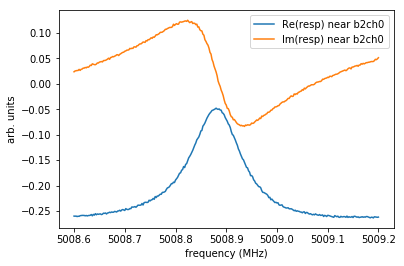

In [101]:
import matplotlib.pylab as plt
import numpy as np

band=2
chIdx=0
etaScan=S.freq_resp[band]['resonances'][chIdx]
freq_eta_scan=etaScan['freq_eta_scan']
resp_eta_scan=etaScan['resp_eta_scan']

plt.plot(freq_eta_scan,np.real(resp_eta_scan),label='Re(resp) near b%dch%d'%(band,chIdx))
plt.plot(freq_eta_scan,np.imag(resp_eta_scan),label='Im(resp) near b%dch%d'%(band,chIdx))
plt.ylabel('arb. units')
plt.xlabel('frequency (MHz)')
plt.legend()
plt.show()

## Time stream data

### How the data was taken

On smurf-srv04.  For this example, I have 410 resonators locked and tracking all together on bands 2 and 3.  Taking a 60 second time stream:

In [5]:
# Load pysmurf
import pysmurf

# Initialize a pysmurf instance connected to the EPICs server named 'test_epics'.  
# Do not run setup (assumes setup was run before this script).  Also assumes you're 
# fully tuned.
S = pysmurf.SmurfControl(make_logfile=False, setup=False, epics_root='test_epics', \
                         cfg_file='/usr/local/controls/Applications/smurf/pysmurf/pysmurf/cfg_files/experiment_fp28_smurfsrv04.cfg')

# Stream data to file for 60 seconds
datadir = S.take_stream_data(meas_time=60)

[ 2019-01-31 09:50:35 ]  Starting to take data.
[ 2019-01-31 09:50:36 ]  Writing PyRogue configuration to file : /data/smurf_data/20190131/1548957035/outputs/1548957036.yml
[ 2019-01-31 09:50:47 ]  Writing to file : /data/smurf_data/20190131/1548957035/outputs/1548957036.dat
[ 2019-01-31 09:50:50 ]  Band 2
[ 2019-01-31 09:50:50 ]  Band 3
[ 2019-01-31 09:50:50 ]  Generating gcp mask file. 215 channels added
[ 2019-01-31 09:50:50 ]  Reading SMuRF to GCP config file
[ 2019-01-31 09:50:50 ]  Reading SMuRF to GCP config file
[ 2019-01-31 09:50:51 ]  caput test_epics:AMCc:FpgaTopLevel:AppTop:AppCore:TimingHeader:userConfig[0] 2
[ 2019-01-31 09:51:51 ]  caput test_epics:AMCc:FpgaTopLevel:AppTop:AppCore:TimingHeader:userConfig[0] 6
[ 2019-01-31 09:51:51 ]  Done taking data.


After initializing a pysmurf instance, we streamed data to file for 60 seconds.  This generated three files in /data/smurf_data/20190130/1548916176/outputs/; 

In [6]:
ls /data/smurf_data/20190130/1548916176/outputs/1548916177*

/data/smurf_data/20190130/1548916176/outputs/1548916177.dat
/data/smurf_data/20190130/1548916176/outputs/1548916177_mask.txt
/data/smurf_data/20190130/1548916176/outputs/1548916177.yml


The .yml file is a record of every PyROGUE register value just before the data was taken.  This allows the configuration of different datasets to be compared register by register:

In [7]:
!head -n 200 /data/smurf_data/20190130/1548916176/outputs/1548916177.yml


AMCc:
  enable: 'True'
  ForceWrite: 'False'
  streamDataWriter:
    enable: 'True'
    dataFile: /data/smurf_data/20190130/1548915790/outputs/1548916090.dat
    open: 'False'
    bufferSize: '0'
    maxFileSize: '0'
  streamingInterface:
    enable: 'True'
    dataFile: ''
    open: 'False'
    bufferSize: '0'
    maxFileSize: '0'
  FpgaTopLevel:
    enable: 'True'
    AmcCarrierCore:
      enable: 'True'
      AxiVersion:
        enable: 'True'
        ScratchPad: '0x000000'
        FpgaReloadHalt: '0x0'
        FpgaReloadAddress: '0x0'
        UserReset: '0x0'
      AxiSysMonUltraScale:
        enable: 'True'
        GIER: '0x0'
        IPIER: '0x0'
        Configuration[0]: '0x0'
        Configuration[1]: '0x21df'
        Configuration[2]: '0x9b00'
        Configuration[3]: '0xf'
        SequenceReg8: '0x0'
        SequenceReg9: '0x0'
        SequenceReg_7_0[0]: '0x4f01'
        SequenceReg_7_0[1]: '0x0'
        SequenceReg_7_0[2]: '0x4f00'
        SequenceReg_7_0[3]: '0x0'
       

Unsurprisingly, it's a ton of info.  Just showing the first 200 lines above.

The *_mask.txt file is a record of which SMuRF channels were assigned to what array indices in the SMuRF .dat file.

In [8]:
!nl -v0 /data/smurf_data/20190130/1548916176/outputs/1548916177_mask.txt

     0	1024
     1	1025
     2	1026
     3	1027
     4	1028
     5	1029
     6	1030
     7	1032
     8	1033
     9	1034
    10	1036
    11	1037
    12	1040
    13	1041
    14	1042
    15	1043
    16	1044
    17	1045
    18	1046
    19	1048
    20	1049
    21	1052
    22	1054
    23	1056
    24	1057
    25	1058
    26	1059
    27	1060
    28	1062
    29	1064
    30	1065
    31	1066
    32	1068
    33	1069
    34	1070
    35	1072
    36	1074
    37	1075
    38	1076
    39	1077
    40	1078
    41	1080
    42	1081
    43	1084
    44	1086
    45	1088
    46	1089
    47	1090
    48	1091
    49	1094
    50	1097
    51	1098
    52	1100
    53	1101
    54	1102
    55	1104
    56	1106
    57	1107
    58	1109
    59	1112
    60	1113
    61	1118
    62	1120
    63	1139
    64	1150
    65	1153
    66	1154
    67	1157
    68	1159
    69	1161
    70	1162
    71	1163
    72	1165
    73	1167
    74	1169
    75	1170
    76	1171
    77	1173
    78	1174
    79	1175
    80	1177
    81	1178
    82	1179
    

Here I've just printed the contents of the mask file with a line number, indexed from zero.  For the existing SMuRF stream transmitter, we can only write 512 channels to file simultaneously.  Each SMuRF 500 MHz band has 512 "CryoChannel" instances, each of which can be configured to track a resonator (otherwise it's just not used).  This mask file encodes the mapping from those channels onto the 512 we're able to save (right now - this will be expanded for SO).  The actual master mask used by the data writer lives somewhere else, but a copy is saved with each dataset so that the mapping is not lost when/if the master changes.  The master mask file lives in the transmitter directory here - /usr/local/controls/Applications/smurf/smurf2mce/master/mcetransmit/mask.txt.  pysmurf knows how to modify it as needed to write the channels you have configured to file - but you have to have a copy of the mask to figure out how to back out which channel ended up at what index in the array saved on disk.

Lastly, the .dat file is data.

### Loading and plotting timestream data

Now we will load the data. The data and mask are assumed to have the same file name, so we will only pass it the datafile. It returns time, data, and the mask.  I'm running this example using SMuRF on my personal machine on the example data directory in these tutorials (see section above for how to unpack the data so you can load it here):

In [29]:
t, dat, mask = S.read_stream_data('example_data\\1548916176\\outputs\\1548916177.dat')

[ 2019-02-03 19:27:48 ]  Treating data as GCP file
[ 2019-02-03 19:27:48 ]  Reading example_data\1548916176\outputs\1548916177.dat


The mask is shape (n_band, n_channel) and is -1 for all unassigned channels and is the array index for the assigned channels. So if mask[2,15] = 4, then band 2 channel 15 is the 4th element (0 indexed) in the datafile.

In [30]:
import numpy as np
np.shape(mask)

(4, 512)

In [31]:
band, channel = np.where(mask != -1)
print(band)
print(channel)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3]
[  0   1   2   3   4   5   6   8   9  10  12  13  16  17  18  19  20  21
  22  24  25  28  30  32  33  34  35  36  38  40  41  42  44  45  46  48
  50  51  52  53  54 

Let us arbitrarily choose a channel and plot it.

In [32]:
idx = 10
print('Band {} Ch {:03}'.format(band[idx], channel[idx]))
print(mask[band[idx],channel[idx]])

Band 2 Ch 012
10


t[0]=1548916190854031799


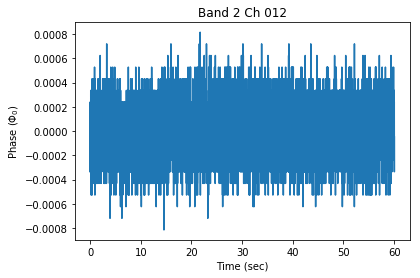

In [47]:
import matplotlib.pyplot as plt
dat_ch=dat[mask[band[idx], channel[idx]]]
t_sec=(t-t[0])/1.e9
print('t[0]=%d'%(t[0]))
plt.plot(t_sec,dat_ch-np.mean(dat_ch))
plt.title('Band {} Ch {:03}'.format(band[idx], channel[idx]))
plt.ylabel('Phase ($\Phi_{0}$)')
plt.xlabel('Time (sec)')
plt.show()

The timestamp is in ns since Jan 1, 1970 (<a href="https://en.wikipedia.org/wiki/Unix_time">because it's awesome</a>) and the y axis is in units of the SQUID flux quantum.  To convert the units to equivalent TES current, just multiply by 

In [52]:
print('%f pA/phi0'%(S.pA_per_phi0/(2.*np.pi)))

1432394.487827 pA/phi0


where pA_per_phi0 is in the config file that was loaded when pysmurf was instantiated.  pA_per_phi0 is a function of the coupling (mutual inductance) of the inductor inline with the TES to the SQUID.

This data was taken at ~180 Hz (set by the MCE syncbox rate).  Here's

white noise level = 33.1 pA/rt.Hz


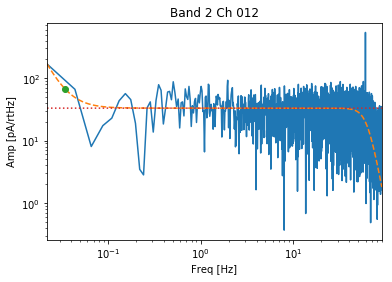

In [77]:
from scipy import signal
pA_ch=dat[mask[band[idx], channel[idx]]]*S.pA_per_phi0/(2.*np.pi)
f, Pxx = signal.welch(pA_ch, nperseg=2**13, fs=180, detrend='constant')
Axx = np.sqrt(Pxx)  # pA
plt.plot(f,Axx)

plt.title('Band {} Ch {:03}'.format(band[idx], channel[idx]))
plt.gca().set_xlabel('Freq [Hz]')
plt.gca().set_xlim(f[1],f[-1])
plt.gca().set_ylabel('Amp [pA/rtHz]')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

popt,pcov,f_fit,Pxx_fit = S.analyze_psd(f,Axx)
wl,n,f_knee = popt

plt.plot(f_fit,Pxx_fit,linestyle = '--',label=r'$n=%.2f$' % (n))
plt.plot(f_knee,2.*wl,linestyle = 'none',marker = 'o',label=r'$f_\mathrm{knee} = %.2f\,\mathrm{Hz}$' % (f_knee))
plt.plot(f_fit,wl + np.zeros(len(f_fit)),linestyle = ':',label=r'$\mathrm{wl} = %.0f\,\mathrm{pA}/\sqrt{\mathrm{Hz}}$' % (wl))
print('white noise level = %0.1f pA/rt.Hz'%(wl))

This channel doesn't have any TES on it - this is just SQUID+resonator noise (and dominated by resonator TLS noise).  The large spike on the right is 60Hz.

## Tracking setup data

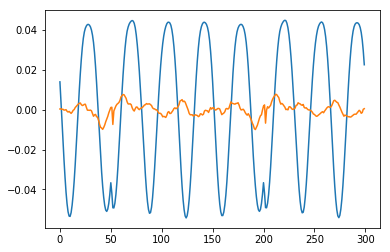

In [102]:
f, df, sync = S.decode_data('example_data\\1549243856\\outputs\\1549244377.dat')
npts=300
idx=2
plt.plot(f[:,idx][:npts]-np.mean(f[:,idx][:npts]))
plt.plot(df[:,idx][:npts]-np.mean(df[:,idx][:npts]))

## IV data 

In [9]:
fn_iv_raw_data='example_data\\1549243856\\outputs\\1549244462_iv_raw_data.npy'
S.analyze_slow_iv_from_file(fn_iv_raw_data, make_plot=True,
            show_plot=True, save_plot=False)

[ 2019-03-07 21:24:50 ]  Analyzing from file: example_data\1549243856\outputs\1549244462_iv_raw_data.npy


OSError: /data/smurf_data/20190203/1549243856/outputs/1549244462_mask.txt not found.